# Assignment 1: Sentiment Polarity for Film Reviews



## Part 1: Parsing the dataset

The dataset is first fetched and unzipped. The arrays `X_raw` and `y` are built, containing all the reviews and their labels respectively, in the same order.

In [1]:
!wget -N http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

--2022-04-19 22:41:46--  http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘review_polarity.tar.gz’ not modified on server. Omitting download.



In [2]:
# untar the .tar.gz file
import tarfile
file = tarfile.open('review_polarity.tar.gz')
file.extractall('./review_polarity')
file.close

<bound method TarFile.close of <tarfile.TarFile object at 0x7f90329b43d0>>

In [3]:
# store the reviews and their labels in arrays

import os
import numpy as np

def build_set(pos_or_neg):
  '''Stores the reviews and their labels in lists'''
  folder = os.listdir(f'./review_polarity/txt_sentoken/{pos_or_neg}/')
  X_raw = []
  y = []
  if pos_or_neg == 'pos':
    binary = 1
  else:
    binary = -1
  for f in folder:    
    text = open(f'./review_polarity/txt_sentoken/{pos_or_neg}/{f}', 'r')
    X_raw.append(text.read())
    y.append(binary)
  return X_raw, y

# the sets are first built separately (pos and neg) for convenience, and then combined
X_pos, y_pos = build_set('pos')
X_neg, y_neg = build_set('neg')

X_raw = X_pos + X_neg
y = y_pos + y_neg

X_raw = np.asarray(X_raw)
y = np.asarray(y)


## Part 2: Feature extraction

This part creates a sorted list of vocabulary and a look up table that maps its words to their corresponding indices. The vocabulary is sorted for better reference. The reviews are then split into training and test sets and vectorised by bag-of-word representations.

In [4]:
# create list of vocabulary and look up table

vocabulary = set()
for review in X_raw:
  vocab_in_review = review.split()
  for word in vocab_in_review:
    vocabulary.add(word)

ordered_vocabulary = sorted(list(vocabulary))
lut = dict()
for i, word in enumerate(ordered_vocabulary):
  lut[word] = i


In [5]:
def countvec(X_to_vectorize):
  '''Vectorises the documents with the bag-of-words representation'''
  X = np.zeros((len(X_to_vectorize), len(vocabulary)), dtype=int)
  for i, review in enumerate(X_to_vectorize):
    vocab_in_review = set(review.split())
    for word in vocab_in_review:
      X[i][lut[word]] = 1
  return X


In [6]:
# Split the data into balanced training and test sets
boundary = int(len(X_pos)*0.8) # we have the same number of pos and neg reviews
X_train_raw = X_pos[:boundary] + X_neg[:boundary]
X_test_raw = X_pos[boundary:] + X_neg[boundary:]
y_train = y_pos[:boundary] + y_neg[:boundary]
y_test = y_pos[boundary:] + y_neg[boundary:]


# vectorise the data sets
X_train = countvec(X_train_raw)
X_test = countvec(X_test_raw)

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

## Part 3: Learning framework 
 
This part builds a learning model `SVM` as a class, which includes calculations for the decision boundary, and the loss function and gradient descent needed for that. There is a `score` method that labels given data with the `predict` method and returns its accuracy.


In [7]:
class SVM:
  def __init__(self, lamb=0.0001, gamma=0.01):
    self.omega = None
    self.lamb = lamb
    self.gamma = gamma

  def fit(self, X, y, maxepoch=2000):
    '''Fits the model, with the loss and gradient descent calculated in the same method. '''
    self.omega = np.zeros(len(X[0])+1)
    self.losses = []
    self.losses_best = []
    self.maxepoch = maxepoch
    epoch = 1
    count = 0
    loss_best = None

    # Add pseudo input
    X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1) 

    while count < 5: # stopping criteria for 5 consecutive iterations
      loss_sum = 0 # summation component of the loss function
      gradient_sum = 0 # summation component of the gradient descent

      # calculate the dot product for the two summation components
      for i, review in enumerate(X):
        pred = np.dot(self.omega.T, review)
        ydotpred = y[i]*pred
        loss_sum += max(0, 1-ydotpred)
        if ydotpred < 1:
          gradient_sum += -y[i]*review

      # calculate the loss
      loss = (self.lamb/2)*(np.linalg.norm(self.omega)**2) + loss_sum
      if loss_best == None: # first iteration
        loss_best = loss
      if loss < loss_best: # new best loss (skip oscillations)
        if loss > loss_best-0.001: # meets stopping criteria
          count += 1
        else: # stops meeting the stopping criteria, restart count
          count = 0
        loss_best = loss
      
      # compile lists of losses for plotting graphs
      self.losses.append(loss)
      self.losses_best.append(loss_best)

      # update omega
      gradient = self.lamb*self.omega + gradient_sum
      self.omega = self.omega - self.gamma * gradient

      if epoch == self.maxepoch: 
        break
      epoch += 1


  def predict(self, X):
    '''Predicts the labels of a given data set with the trained parameters. '''
    preds = []
    # Add pseudo input
    X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1) 

    for i, review in enumerate(X):
      pred = np.dot(self.omega.T, review)
      if pred < 0:
        pred_sgn = -1
      else:
        pred_sgn = 1
      preds.append(pred_sgn)
    return np.asarray(preds)


  def score(self, X, y):
    '''Scores the predictions. '''
    return np.sum(self.predict(X)==y)/len(y)


In [8]:
model = SVM()
model.fit(X_train, y_train)
print(f'Accuracy on training set: {100*model.score(X_train, y_train)}%')
print(f'Accuracy on test set: {100*model.score(X_test, y_test)}%')

Accuracy on training set: 100.0%
Accuracy on test set: 85.5%


Loss over iterations:


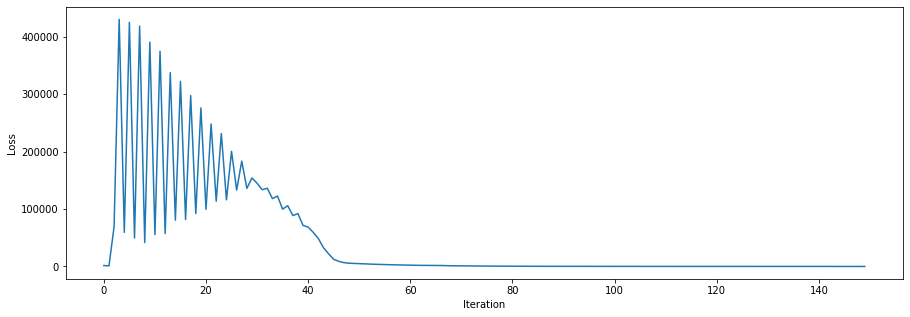


Best loss over iterations:


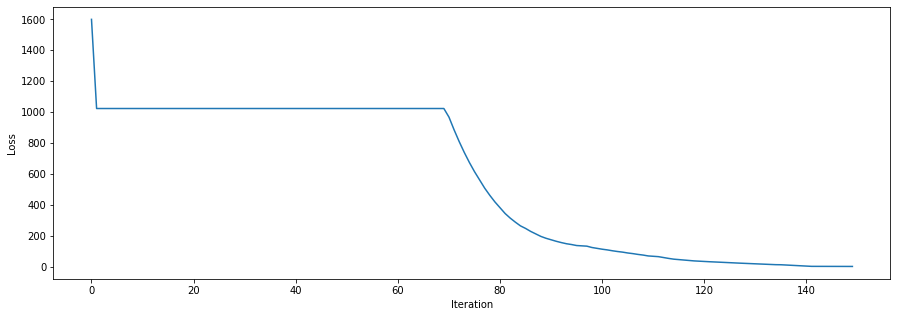

In [9]:
import matplotlib.pyplot as plt

def plot_graph(loss_list): 
  plt.figure(figsize=(15, 5))
  plt.plot(loss_list)
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.show()

print('Loss over iterations:')
plot_graph(model.losses)
print()
print('Best loss over iterations:')
plot_graph(model.losses_best)

## Part 4: Exploring hyperparameters
 
The code below adapts the given code in sampling from a grid search for an optimal learning rate and dampening rate. A simple table ranked by accuracy is shown. The model is then run once again with the best pair of hyperparameters.

A max epoch of 90 is set for the grid search, a higher number of epochs would tend towards achieving 100.0% accuracy (or a similarly high accuracy across most of the hyperparameter pairs), which is not very helpful for this purpose.

In [10]:
from sklearn.model_selection import ParameterSampler

parameter_distribution = {'learning_rate': np.exp(np.linspace(np.log(0.0001), np.log(3), 10)),
                           'reguliser_dampening': np.exp(np.linspace(np.log(0.0001), np.log(3), 10))}

# Placeholder to make future comparisons easier
best_hyperparameters = None

# log our hyperparameters and arruracies in a list to creating a ranked table
samples = []

for hyperparameters in ParameterSampler(parameter_distribution, n_iter=10):
    # Set up the classifier
    reguliser_dampening = hyperparameters['reguliser_dampening']
    learning_rate = hyperparameters['learning_rate']
    model = SVM(lamb=reguliser_dampening, gamma=learning_rate)

    # Train the classifier
    model.fit(X_train, y_train, maxepoch=90)

    # Calculate the training accuracy    
    training_accuracy = np.sum(model.predict(X_train)==y_train)/len(y_train)

    samples.append((reguliser_dampening, learning_rate, training_accuracy))

    # Store the hyperparameters if they are better than what we have found before
    if best_hyperparameters is None or best_hyperparameters[1] < training_accuracy:
      best_hyperparameters = (hyperparameters, training_accuracy)

best_learning_rate = best_hyperparameters[0]['learning_rate']
best_reguliser_dampening = best_hyperparameters[0]['reguliser_dampening']

print('Reg.dampening:\tLearning rate:\tTraining set accuracy:')
samples.sort(key=lambda a:a[2], reverse=True)
for sample in samples:
  print(f'{round(sample[0], 5)}\t\t{round(sample[1], 5)}\t\t{round(sample[2]*100, 1)}%')
print()
print("Best parameters: %.5f, %.5f" % (best_reguliser_dampening, best_learning_rate))

Reg.dampening:	Learning rate:	Training set accuracy:
0.00977		0.09655		99.7%
0.00031		0.95425		99.6%
0.00977		0.00099		99.6%
0.00099		0.00031		99.2%
0.00099		0.95425		98.8%
0.0001		0.0001		81.1%
3.0		0.00031		58.0%
0.30353		0.09655		53.1%
0.00977		3.0		51.9%
3.0		0.30353		50.0%

Best parameters: 0.00977, 0.09655


In [11]:
# Set up the classifier
model = SVM(best_reguliser_dampening, best_learning_rate)

# Train on all the non-test data
model.fit(X_train, y_train)

# Run prediction on the test set
test_accuracy = np.sum(model.predict(X_test)==y_test)/len(y_test)

print("Test set accuracy %.1f%%" % (100*test_accuracy))

Test set accuracy 86.2%


Loss over iterations:


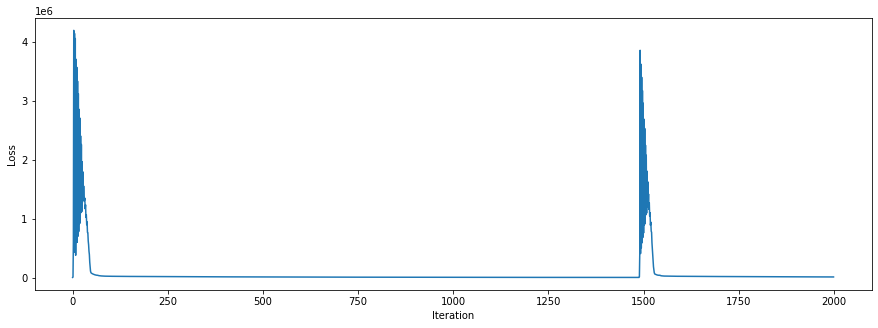


Best loss over iterations:


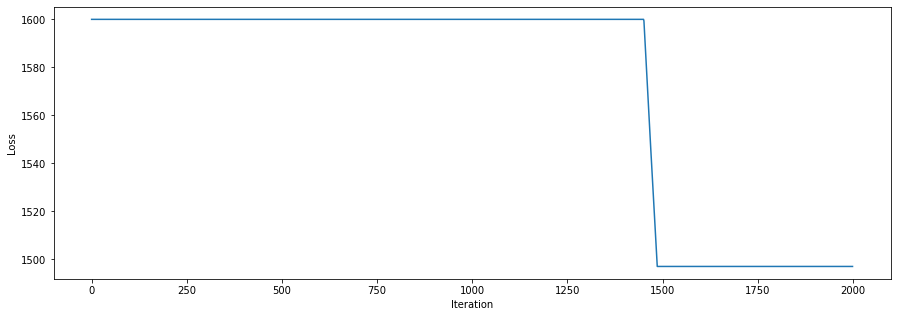

In [12]:
print('Loss over iterations:')
plot_graph(model.losses)
print()
print('Best loss over iterations:')
plot_graph(model.losses_best)

In [13]:
def word_influence(omega):
  assert (len(omega)-1) == len(vocabulary)

  # Sort by absolute value
  idx = np.argsort(np.abs(omega[1:]))

  print("                Word   Weight  Occurences")
  for i in idx[-20:]:   # Pick those with highest 'voting' values
    print("%20s   %.3f\t%i " % (ordered_vocabulary[i], omega[i+1], np.sum([ordered_vocabulary[i] in d for d in X_raw])))

In [14]:
word_influence(model.omega)

                Word   Weight  Occurences
                both   90.801	683 
          ridiculous   -91.920	159 
                 see   94.106	1662 
               looks   -95.779	364 
                many   97.483	796 
                 job   97.807	480 
                also   99.411	1071 
                   ?   -100.189	1228 
                life   101.397	895 
              should   -102.329	708 
              stupid   -102.613	227 
                best   112.473	867 
            supposed   -118.110	321 
              boring   -118.329	229 
             nothing   -122.119	594 
              script   -123.265	632 
       unfortunately   -125.702	329 
                plot   -144.375	1002 
               worst   -146.590	238 
                 bad   -214.366	825 


##Part 5: Comments and Analysis

Our final model achieved an accuracy of 86.2%. The list of word influences above confirms some of our intuitions, where words such as 'bad', 'worst', 'unfortunately', 'boring' and 'best' point to a negative label. However, word occurences may be more varied for positive reviews, and no clear and convincing indications are shown above beside 'best'. The prescence of some functional and neutral words such as 'also' and 'should' in the list may indicate over learning, or there may be implicit patterns ('should' may be used to introduce suggestions in negative reviews). When we take word frequency into account, especially tf-idf, we can eliminate such functional words (including stop words) and avoid misinterpretations by the model.

The selected hyperparameters are picked from a sample of 10 out of 100, hence this set of hyperparameters may not be the 'best', but good enough. The loss tends to get large when the learning rate is high, and the loss tends to drop more when the dampening is larger. From our sampling search, we can see that the learning rate cannot be too high, unless the dampening is low.

The pipeline design is rather straightforward. Some steps are written in functions since there had been an attempt to try out some VG extensions, and it is more flexible to apply different approaches this way. It may be even cleaner and easier to manipulate if a class is created for the data.

Parsing apart the equations for fitting the model is the most challenging, but at the same time the most educational. It took a necessary while to understand the equations and to implement them, but I have learnt the most when, during this process, I had to thoroughly visualise how we utilise our data in the form of arrays and vectors, and in much details what should happen in the pipeline when we have correct and wrong classifications.

